#### Data 620 - Project 1 <br>June 19, 2019<br>Team 2: <ul> <li>Anthony Munoz</li> <li>Katie Evers</li> <li>Juliann McEachern</li> <li>Mia Siracusa</li></ul>

<h1 align="center">"Network Analysis"</h1>

## Project Overview

We choose to analyze NYC OpenData's [Women Resources Network Database](https://data.cityofnewyork.us/Social-Services/NYC-Women-s-Resource-Network-Database/pqg4-dm6b). The dataset includes 59 variables by columns and 1,147 rows as of the most recent web update on Nov 7, 2018.

Our focus will be on the identified organizations that serve New York City women and families. We will map the network connections by organization and the NYC borough in which they operate. Each node contains categorical information on whether or not the organization is a government agency.

#### Python Dependencies

The following packages are required for replication of our work.  

In [1]:
import networkx as nx, pandas as pd, numpy as np, re, matplotlib.pyplot as plt, warnings, seaborn as sns

from sodapy import Socrata
from pandas.plotting import scatter_matrix

warnings.filterwarnings('ignore') 

#### Dataset Selection

NYC OpenData was accessed using the `Socrata API`. A copy of the results was also preserved in our repository as a csv file. 

The Women Resources Network Database was obtained from the client connection below and stored in a pandas dataframe. Unused columns were dropped and the data was transformed from a wide to long format to show the connection between organization and boroughs. Government organization classifications were retained as edge attributes. 

In [2]:
client = Socrata("data.cityofnewyork.us",None)
results = pd.DataFrame(client.get("pqg4-dm6b", limit=2000))
#results.to_csv('results.csv') --> unhash to save results

# drop unused columns 
unused = ['address1', 'address2', 'bbl', 'bin','borough', 'census_tract', 'nonprofit','fax','is_registered_with_the_attorney_general_s_office','latitude','longitude','location_1','phone', 'city', 'community_board', 'community_council', 'postcode', 'published', 'url', 'nourl','description', 'outsideloc', 'outsidelocdesc', 'nta', 'aging', 'anti_discrimination_human_rights', 'arts_culture', 'child_care_parent_information', 'community_service_volunteerism', 'counseling_support_groups', 'disabilities', 'domestic_violence', 'education', 'employment_job_training', 'health', 'homelessness', 'housing', 'immigration', 'legal_services', 'lesbian_gay_bisexual_and_or_transgender', 'none_of_the_above', 'personal_finance_financial_education', 'veterans_military_families', 'victim_services', 'youth_services','professional_association', 'faith_based_organization','foundation', 'business']
results=results.reindex(results.columns.drop(unused), axis=1)

# reorder columns
org =['organizationname']
boro=['bronx', 'brooklyn', 'manhattan', 'queens', 'staten_island']
gov = ['new_york_city_agency','other_government_organization']


# transform dataframe from wide to long
t = results.melt(id_vars=org+gov, value_vars=boro,
                 var_name='boro').query("value == 'Y'").drop('value', axis=1)

# transform government column to include nyc agencies and other government organizations
def newcol(row):
    if row['new_york_city_agency'] == "Y":
        val = "Y"
    elif row['other_government_organization'] == "Y":
        val = "Y"
    else:
        val = "N"
    return val

t['gov_agency'] = t.apply(newcol, axis=1)

# subset dataframe to include only necessary columns
df = t[['organizationname', 'boro', 'gov_agency']].reset_index().drop('index', axis=1)

# preview dataframe
df.head()

,organizationname,boro,gov_agency
0,RightRides for Women's Safety,bronx,N
1,American-Italian Cancer Foundation's Mobile Ma...,bronx,N
2,Legal Momentum,bronx,N
3,Young Mothers Program/BBBS,bronx,N
4,Federally Employed Women (FEW),bronx,N


## Network Graph

#### Build Network

We built our graph using `networkx` and the force-directed, `kamada_kawai_layout` layout. 

In [3]:
# create graph & set Kamada-Kawai force-directed layout.
g = nx.from_pandas_edgelist(df, source='boro', target='organizationname',edge_attr=True)
layout = nx.kamada_kawai_layout(g, scale=10)

In [4]:
# set network lists for drawing graph
## unique list of all nyc boroughs & set colors for each borough
boro_name = list(df.boro.unique())
boro_col = ['#78c2c1', '#774EA3', '#7ba8c8','#A34E7A','#4EA377']


## unique list of all government organizations
gov_u = [(u) for (u, v, c) in g.edges.data('gov_agency') if not (u in boro_name or c == "N")]
gov_v = [(v) for (u, v, c) in g.edges.data('gov_agency') if not (v in boro_name or c == "N")]
gov_org = list(set(gov_v+gov_u))

## unique list of all non-government organizations
non_gov = [x for x in list(df.organizationname.unique()) if x not in gov_org]

## unique list of all organizations
all_orgs = list(df.organizationname.unique())

#### Visualize Network

The code below builds our network of NYC Women Resources. The size of our borough nodes have been amplified for better visualization their connections to other organizational nodes. The non-government nodes have been drawn in light gray and the government nodes can be seen in black. The edges have been drawn in gray as well to show the path in which our organizations and boroughs are connected. 

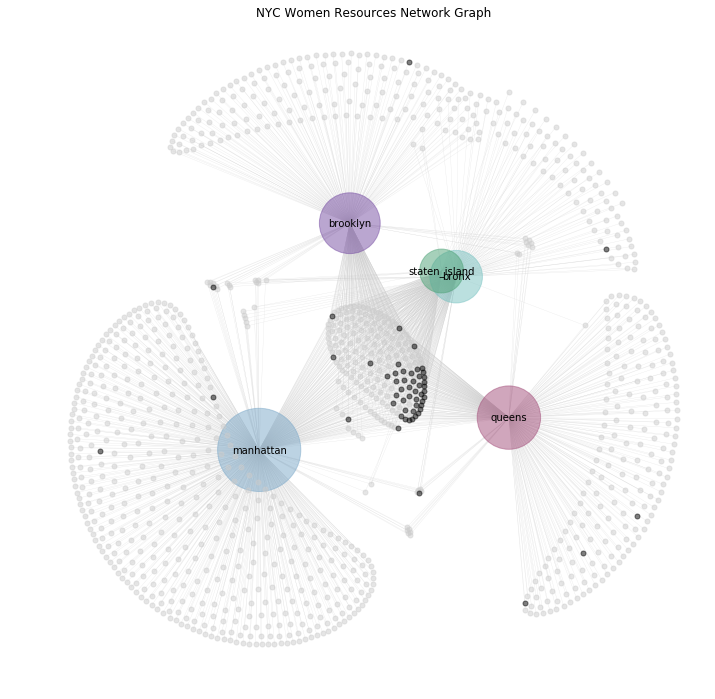

In [5]:
plt.figure(figsize=(12, 12))

# draw borough nodes
bsize = [g.degree(boro_name) * 10 for boro_name in boro_name]
nx.draw_networkx_nodes(g, layout, alpha = .5, nodelist=boro_name, node_size=bsize, node_color=boro_col)

# draw non_gov nodes
nx.draw_networkx_nodes(g, layout, alpha=.5, nodelist=non_gov, node_size=25, node_color='#cccccc')

# draw gov nodes 
nx.draw_networkx_nodes(g, layout, alpha=.5, nodelist=gov_org, node_size=25, node_color='#000000')

# draw edges with color
edges = g.edges()
nx.draw_networkx_edges(g, layout, width=0.25, alpha=.5, edge_color='#c6c6c6')

node_labels = dict(zip(boro_name, boro_name))
nx.draw_networkx_labels(g, layout, labels=node_labels, font_size=10)

## plot graph
plt.axis('off')
plt.title('NYC Women Resources Network Graph')
plt.show()

## Network Analysis

Through a visual examination of our network, we can tell that the majority of organizations operate in Manhattan. Government agencies predominately operate in more than one borough. And, Staten Island appears to have the least amount of unique organizations that provide services solely in that borough. 

The following information provides a basic overview of our network:

In [6]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 1138
Number of edges: 1933
Average degree:   3.3972


The output below confirms our visual assumptions. Manhattan has the largest number of connections while Staten Island and the Bronx have the least. 

In [7]:
gd=pd.DataFrame(g.degree(boro_name)).sort_values(1,ascending =False).rename({0:'BORO:',1:'DEGREE'}, axis=1).set_index("BORO:")
print("Degree of Boroughs: \n", gd)

Degree of Boroughs: 
                DEGREE
BORO:                
manhattan         692
queens            402
brooklyn          370
bronx             276
staten_island     193


We can also look at degree patterns by government association. From this, we can further confirm our visual assumptions as the data shows most government agencies operate in all five boroughs, while most non-government organizations provide services to individual boroughs. 

In [8]:
gd=pd.DataFrame(g.degree(gov_org)).sort_values(1,ascending =False).rename({0:'COUNT',1:'DEGREE'}, axis=1).groupby('DEGREE')['COUNT'].nunique()
print("Degree of Government Agencies: \n", pd.DataFrame(gd))

ng=pd.DataFrame(g.degree(non_gov)).sort_values(1,ascending =False).rename({0:'COUNT',1:'DEGREE'}, axis=1).groupby('DEGREE')['COUNT'].nunique()
print("\nDegree of Non-Government Organizations: \n", pd.DataFrame(ng))

Degree of Government Agencies: 
         COUNT
DEGREE       
1           7
2           1
3           1
4           2
5          44

Degree of Non-Government Organizations: 
         COUNT
DEGREE       
1         890
2          27
3          19
4          18
5         124


## Centrality Measures

In the following sections, we will further analyze our network attributes using centrality measures. For comparing purposes, we will gain further insight on our network through examination of the following measures:

1. **Degree:**  Degree centrality calculates the a fraction of the number of neighbor nodes associated with a nodes.
2. **Betweenness:**  Betweenness centrality meaures the shortest-path between nodes.
3.  **Closeness:** Closeness centrality focuses on how close the nodes can be to the other nodes. 
4.  **Eigen:** The eigenvector centrality locates nodes that are well connected with other nodes and calculates their connections.

#### Centrality Calculations

To conduct this analysis, we built a new dataframe that shows degree, betweenness, closeness, and eigenvector centrality measures for all of our network nodes. We can see here that Manhattan has the highest degree, betweenness, closeness, and eigenvector centrality measures.

In [9]:
# create dataframe of graph centrality measures
cm = pd.DataFrame()
cm['degree'] = nx.degree_centrality(g).values()
cm['betweenness'] = nx.betweenness_centrality(g).values()
cm['closeness'] = nx.closeness_centrality(g).values()
cm['eigen'] = nx.eigenvector_centrality_numpy(g).values() 
cm.index = list(g)

# view centrality measures across boroughs
dat = cm.reset_index()
dat.sort_values('degree' ,ascending = False).head(5)

,index,degree,betweenness,closeness,eigen
456,manhattan,0.608619,0.671518,0.562037,0.439751
931,queens,0.353562,0.323519,0.436804,0.304203
277,brooklyn,0.325418,0.269642,0.426322,0.297967
0,bronx,0.242744,0.132343,0.398249,0.267960
1124,staten_island,0.169745,0.029982,0.376365,0.231284


We then merged our original dataframe and our calculated centrality measures to create a new network dataframe for categorical analysis later on. 

In [10]:
network = pd.merge(df, cm, how='inner', left_on = 'organizationname', right_on = cm.index)
network.head()

,organizationname,boro,gov_agency,degree,betweenness,closeness,eigen
0,RightRides for Women's Safety,bronx,N,0.003518,0.002051,0.494993,0.038043
1,RightRides for Women's Safety,brooklyn,N,0.003518,0.002051,0.494993,0.038043
2,RightRides for Women's Safety,manhattan,N,0.003518,0.002051,0.494993,0.038043
3,RightRides for Women's Safety,queens,N,0.003518,0.002051,0.494993,0.038043
4,American-Italian Cancer Foundation's Mobile Ma...,bronx,N,0.004398,0.002179,0.501102,0.044761


#### Visualizing Centrality Measures

The plots below show that none of our centrality measures follow a normal distribution. Degree, eigenvector, and betweenness have a bimodal distribution. Closeness is multimodal and skewed to the left.  

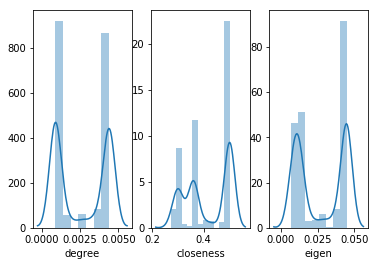

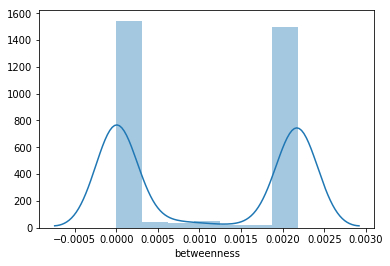

In [11]:
fig, ax = plt.subplots(1, 3)

sns.distplot(network.degree, ax=ax[0])
sns.distplot(network.closeness, ax=ax[1])
sns.distplot(network.eigen, ax=ax[2])

plt.show()

sns.distplot(network.betweenness)
plt.show()

####  Correlation of Centrality Measures 

Next, we did a correlation analysis on the 4 centrality measure to look for a relation between them. We found that "degree" and "betweenness" are a very strong positive (0.970817) and that "closeness" and "betweenness"(0.127033) has the weakest relationship when it comes to correlation variables.

In [12]:
# correlation between the measures centrality 
su_df = dat[['degree','betweenness','closeness','eigen']]
su_df.corr()

,degree,betweenness,closeness,eigen
degree,1.000000,0.970817,0.140233,0.857442
betweenness,0.970817,1.000000,0.127033,0.788120
closeness,0.140233,0.127033,1.000000,0.585895
eigen,0.857442,0.788120,0.585895,1.000000


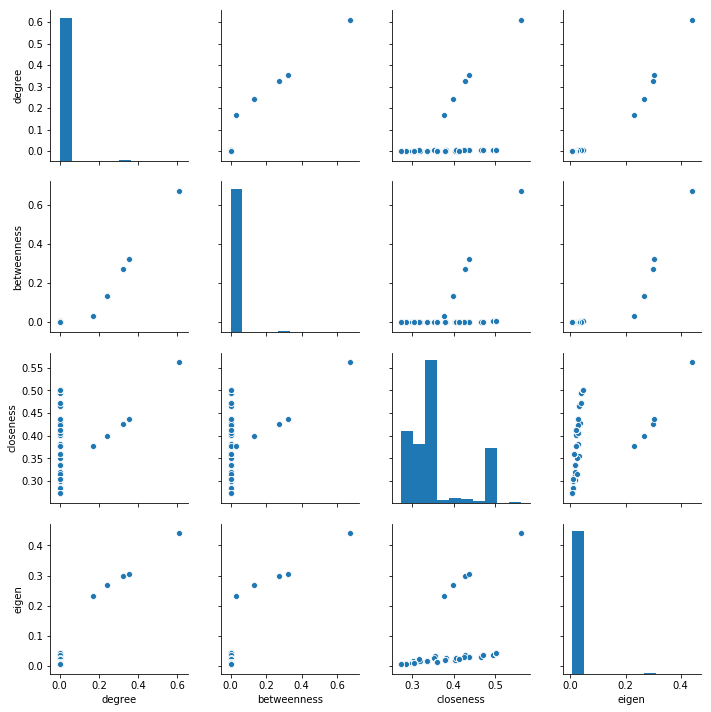

In [13]:
sns.pairplot(dat)

#### Centrality Measures Comparisons

After visualizing our measures, we aggregated our calculations from this dataframe by borough and government association. By grouping our data, we were able to examine the mean centrality measures for all organizations against these categorical features. Our results indicate that there are differences in our calculated centrality measures based on government affiliation. On average, government organizations show higher levels of degree, betweenness, closeness, and eigenvector centrality measures. 

In [14]:
grouped=network.groupby(['boro','gov_agency'], as_index='boro').mean()[['degree', 'betweenness', 'closeness', 'eigen']]
grouped

degree  betweenness  closeness     eigen
boro          gov_agency                                            
bronx         N           0.003097     0.001365   0.425119  0.031419
              Y           0.004267     0.002107   0.494982  0.043504
brooklyn      N           0.002503     0.001006   0.395128  0.025538
              Y           0.004233     0.002087   0.494088  0.043220
manhattan     N           0.001709     0.000519   0.393811  0.020360
              Y           0.004134     0.002026   0.491458  0.042417
queens        N           0.002321     0.000908   0.388059  0.023765
              Y           0.004116     0.002014   0.487263  0.042008
staten_island N           0.003976     0.001878   0.473092  0.040250
              Y           0.004378     0.002167   0.500446  0.044588